# Philo - Cold Gas Engine Simulator
-------------------------------------------------------------
A small-scale cold gas VTVL rocket

By: Ara Kourchians

In [49]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


The goal of this notebook is to outline the process for determining the optimal engine parameters for a cold gas rocket engine, as well as an estimate time of flight assuming a hover. It's important to keep in mind that the values we generate have to be realistic and reasonable. Once we obtain these rough numbers, we can evaluate and tune them to match existing COTS, and if necessary, fabricate custom parts.

Before we dive in, we must first state our assumptions and initial parameters. The assumptions allow us to simplify the model, while the initial parameters give us a starting point to work from.


### Assumptions
1. Processes within the engine are Isentropic
2. Flow is choked at the throat of the nozzle where Ma = 1
3. Pb = 101.325kPa (Ambient Pressure)
4. Tb = 298.15K (Ambient Temperature)
5. Propellant acts as an Ideal Gas (we will later model this as a real gas)

### Initial Vehicle Model
1. Propellant:       Air, cp = 0.846, cv = 0.657, gamma = 1.28
2. Dry mass        = 1.89kg
3. Propellant mass = 0.53kg

In [50]:
# Environment Properties
P_atm = 101325           # Pa (Ambient Pressure)
T_atm = 298.15           # K (Ambient Temperature)
T_o = 298.15             # K (Tank Temperature)
R = 8.314                # J/(K*mol)
g = 9.81                 # m/s^2

# Propellant Properties 
cp = 1.005               # Constant pressure specific heat
cv = 0.718               # Constant volume specific heat
molar_mass = 0.02897     # kg/mol
gamma = cp/cv            # Specific Heat Ratio

# Vehicle Properties
dry_mass = 1.89                     # kg (rough estimation based on current design)
prop_mass = 0.53                    # kg (based on tank capacity and gas)
wet_mass = dry_mass + prop_mass     # kg
tank_volume = 0.00147484            # m^3

### Approach:

> <b>Understand the Basics</b>

> Step 1: Determine Theoretical Maximum Flight Time

> Step 2: Determine Critical Properties

> <b>Calculate Parameters for a Minimal/Simple Design (Ma = 1)</b>

> Step 3: Determine Velocity at the Throat

> Step 4: Determine Cross-Sectional Area at the Exit of the Nozzle

> Step 5: Determine Flight Time

> <b>Calculate Parameters for an Optimized Design (Ma > 1)</b>

> Step 6: Optimize Flight Time by varying Nominal Chamber Pressure

> Step 7: Determine Cross-Sectional Area at the Exit and Throat

> <b>Accurately Model Propellant and Tank Properties</b>

> Step 8: Model Propellant as a Real Gas

> Step 9: Recalculate Vehicle and Engine Parameters

#### Step 1: Determine Theoretical Maximum Flight Time

This will be driven by our initial assumptions and vehicle model. With these parameters we can determine the theoretical maximum flight time using the rocket equation to solve for delta_V, and dividing that by the gravity vector to obtain flight time:

\begin{equation}
V_\Delta = V_e * ln\left(\frac{m_o}{m_f} \right) \tag{1} 
\end{equation}

Where V_e_expected = ~1000m/s   (Based on Figure 2-5 of "Rocket Propulsion Elements")

In [51]:
v_e_expected = 1000   # m/s (APPROXIMATION)

delta_v = v_e_expected * np.log(wet_mass/dry_mass)

print ("Delta V: %0.2f m/s" % delta_v)

Delta V: 247.19 m/s


Divide by the gravity vector to obtain flight time:

In [52]:
t_theoretical = delta_v / g

print ("Theoretical Flight Time: %0.2f sec" % t_theoretical)

Theoretical Flight Time: 25.20 sec



#### Step 2: Determine Critical Properties
In order to solve for the critical properties, we must first make note of the following key concepts regarding nozzles and choked flow:

> * V = Velocity
> * A = Area
> * Rho = density

TODO: Define all variables above

> * The critical properties and critical ratios (Eqs 4, 5, and 6) are a direct function of the propellant properties and the pressure differential of the chamber and exit.

> * A converging section of the nozzle is required to bring subsonic flow to sonic flow.

> * A diverging section of the nozzle, following the throat (minimum area), is required to bring the sonic flow to supersonic flow.

<img src="subsonic_flow.png">
<img src="supersonic_flow.png">

> * Choked flow occurs when the chamber properties (P_o & T_o) are greater than or equal to the product of the exhaust properties (P_b & T_b) and the critical ratios.

> * At choked flow, mass flow rate is <b>constant</b>.

To better understand why we must have a converging diverging nozzle, we plot the following area ratio equation (Eq 3), which is derived from Equations 2, 5, 6, and 10. 

\begin{equation}
\rho A V = constant = \rho^* A^* V^* \tag{2}
\end{equation}

\begin{equation}
\frac{A}{A_*} = \frac{1}{Ma}\left[ \frac{1+\frac{\gamma-1}{2}Ma^2}{1+\frac{\gamma-1}{2}} \right]^\frac{\gamma+1}{2(\gamma-1)} \tag{3} 
\end{equation}

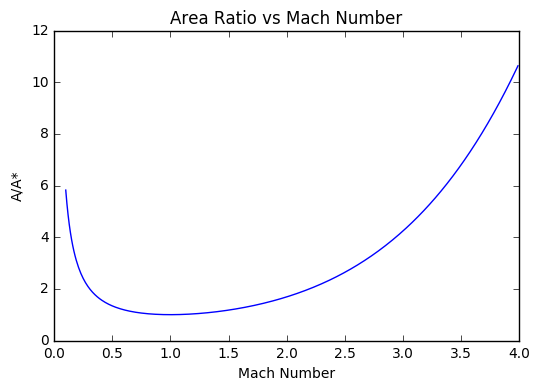

In [53]:
def area_ratio(Ma):
    
    A_ratio = (1/Ma)*(((1+((gamma-1)/2)*(Ma**2))/(1+((gamma-1)/2)))**((gamma+1)/(2*(gamma-1))))
    
    return A_ratio

ma_array = np.arange(0.1, 4, 0.01)
A_array = area_ratio(ma_array)

plt.figure(1)
plt.xlabel('Mach Number')
plt.ylabel('A/A*')
plt.title('Area Ratio vs Mach Number')
plt.plot(ma_array, A_array)
plt.show()

Notice how the area ratio decreases as Mach number increases. The area ratio reaches a minimum when Ma=1, where by after, the area ratio begins to increase.

To calculate the critical ratios:

\begin{equation}
\frac{P_o}{P} = \left[1+\left(\frac{\gamma-1}{2}\right)Ma^2\right]^\frac{\gamma}{\gamma-1} \tag{4} 
\end{equation}

\begin{equation}
\frac{T_o}{T} = 1+\left(\frac{\gamma-1}{2}\right)Ma^2 \tag{5} 
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho} = \left[1+\left(\frac{\gamma-1}{2}\right)Ma^2\right]^\frac{1}{\gamma-1} \tag{6} 
\end{equation}

\begin{equation}
M_a = \sqrt{\frac{2}{\gamma-1}\left(\left(\frac{P_o}{P}\right)^{\frac{\gamma-1}{\gamma}} - 1\right)} \tag{7} 
\end{equation}

To calculate the critical properties:

\begin{equation}
\frac{P_o}{P_*} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_*} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho_*} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{1}{\gamma-1}
\end{equation}

Since our back pressure is fixed to 101.325kPa (1atm), we need to work back what the minimum required chamber pressure is in order to achieve choked flow:

\begin{equation}
\frac{P_o}{P_b} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_b} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho_b} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{1}{\gamma-1}
\end{equation}

In [54]:
# Calculate Minimum Chamber Properties

Ma_t = 1.0     # Minimum mach number required to achieve choked flow is 1
P_b = P_atm

P_o = P_b*(((1+((gamma-1)/2)*(Ma_t**2))**(gamma/(gamma-1))))
T_b = T_o/(1+(((gamma-1)/2)*(Ma_t)))

P_o_critical = P_o

print ("Choked Flow:")
print ("Ma_t: %.2f" % Ma_t)
print ("Given Exit/Throat Pressure: %.2f Pa" % P_b)
print ("Calculated Chamber Pressure (Critical Pressure): %.2f Pa" % P_o)
print ("Given Chamber Temperature: %.2f K" % T_o)
print ("Calculated Exit/Throat Temperature: %.2f K" % T_b)

Choked Flow:
Ma_t: 1.00
Given Exit/Throat Pressure: 101325.00 Pa
Calculated Chamber Pressure (Critical Pressure): 191784.01 Pa
Given Chamber Temperature: 298.15 K
Calculated Exit/Throat Temperature: 248.49 K


Recall, a converging nozzle can only ever achieve an exhaust velocity of Ma=1. In order to accelerate the exhaust velocity to supersonic speeds we must add a diverging section after the throat. 

For now, we will solve for Ma=1 at the exit, and later increase it during our optimization step.

#### Step 3: Determine Velocity at the Throat

Now that we know the the minimum chamber pressure and temperature, we can calculate the expected minimum exit velocity at the throat (V_th) using the following equation:

Where c is the sound velocity:

\begin{equation}
c = \sqrt{\frac{\gamma R T}{m_{molar}}} \tag{8} 
\end{equation}

\begin{equation}
M_a = \sqrt{\frac{2}{\gamma-1}\left( \left(\frac{P_o}{P_b}\right)^{\frac{\gamma-1}{\gamma}} - 1 \right)} \tag{9} 
\end{equation}

\begin{equation}
V = M_ac \tag{10} 
\end{equation}

Combined:

\begin{equation}
V = \sqrt{\frac{T_b R}{m_{molar}}*\frac{2 \gamma}{\gamma-1}*\left(\left(\frac{P_o}{P_b}\right)^{\frac{\gamma-1}{\gamma}}-1\right)} \tag{11} 
\end{equation}

In [55]:
V_th = np.sqrt(((T_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * ((P_o / P_b) ** (
        (gamma - 1) / gamma)) -1 )

Isp = V_th / g

print ("Velocity at throat: %.2f m/s" % V_th)
print ("Specific Impulse (throat only): %2f sec" % Isp)

Velocity at throat: 774.11 m/s
Specific Impulse (throat only): 78.910697 sec


#### Step 4: Determine Cross-Sectional Area at the Exit of the Nozzle

Next we must solve for the cross-sectional area at the exit of the nozzle in order to determine the cross-sectional area at throat. However, in order to do this, we much select our desired nominal thrust then solve for the mass flow rate using the following equation:

\begin{equation} 
F = \dot{m}*V_e + A_e(P_e - P_{atm})
\end{equation} 

\begin{equation}
F = \dot{m}*V_{th}
\end{equation}

Rewritten as:

\begin{equation}
\dot{m} = \frac{F}{V_{th}} \tag{12} 
\end{equation}

In order to determine the desired nominal thrust, we must calcuate the force necessary to null out the acceleration of a fully loaded rocket:

\begin{equation}
F_{nominal} = m_{wet} * g \tag{13} 
\end{equation}

Of course, this force will change as the vehicle loses mass, but it gives us a place to start.

In [56]:
F_nom = wet_mass * g

print ("Nominal Engine Thrust: %.2f N" % F_nom)

Nominal Engine Thrust: 23.74 N


With our nominal thrust, we can now work out the mass flow rate:

In [57]:
mass_flow = F_nom / V_th         # kg/s

print ("Mass Flow Rate: %.6f kg/s" % mass_flow)

Mass Flow Rate: 0.030668 kg/s


Using the mass flow rate, we can now determine the cross-sectional area at the exit using the following equation:

\begin{equation}
A_e = \frac{\dot{m}* \frac{R T_e}{m_{molar}} }{V_e P_e} \tag{14} 
\end{equation}

To solve for A_e we must substitute P_e (Eq 4), T_e (Eq 6), and V_e (Eq 11):

\begin{equation}
A_e = \frac{\dot{m}* \left(1+(\gamma-1)\frac{Ma_e^2}{2}\right)^\frac{\gamma+1}{2(\gamma-1)}}{Ma_e P_o\sqrt{\frac{\gamma * m_{molar}}{R T_o}}}
\end{equation}

Since we are solving for the area at the exit of the nozzle, we assume only a converging nozzle and an exit mach number of 1: \begin{equation} M_a = 1 \end{equation}

In [58]:
P_e = P_b
T_e = T_b

A_e = (mass_flow*(1+(gamma-1)*((Ma_t**2)/2))**((gamma+1)/(2*(gamma-1))))/(Ma_t*P_o*np.sqrt((molar_mass*gamma)/(R*T_o)))

print ("Cross-sectional Area at Exit: %.8f m^2" % A_e)
print ("Cross-sectional Area at Exit: %.2f mm^2" % (A_e*1e6))

print ("Exit Diameter: %.2f mm" % (2*(np.sqrt((A_e*1e6)/np.pi))) )

Cross-sectional Area at Exit: 0.00006832 m^2
Cross-sectional Area at Exit: 68.32 mm^2
Exit Diameter: 9.33 mm


Note: This cross-sectional area will change when we increase the exit velocity.

#### Step 5: Determine Flight Time

We can now estimate the time of flight by dividing the total propellant mass by mass flow rate:

\begin{equation}
t_{flight} = \frac{m_{prop}}{\dot{m}} \tag{15} 
\end{equation}

It's important to note that this is an approximation and that this model does not compensate for thrust adjustment.. so yes, the vehicle will begin to accelerate as it loses mass. In order to get more accurate ToF approximations, we will solve for a new desired thrust and adjust it in our flight sim using numerical approximation.

In [59]:
t_flight = prop_mass / mass_flow    # sec

print ("Time of Flight: %0.2f sec" % t_flight)

Time of Flight: 17.28 sec


#### Step 6: Optimize Flight Time by varying Nominal Chamber Pressure

Now that we know the minimum pressure required for choked flow, and the required cross-sectional area and exit velocity to null out the vehicles gravity vector, we can now sweep the chamber pressure to find optimimal parameters for maximizing flight time.

<b> IMPORTANT: From this point forward, we are going to exceed mach numbers of 1. Meaning, our nozzle now must have a converging and diverging section.</b>
<br><br>
Flight time optimization goals:
1. Increase P_o to increase time of flight
3. Optimization shall our assumptions and vehicle model
<br><br>

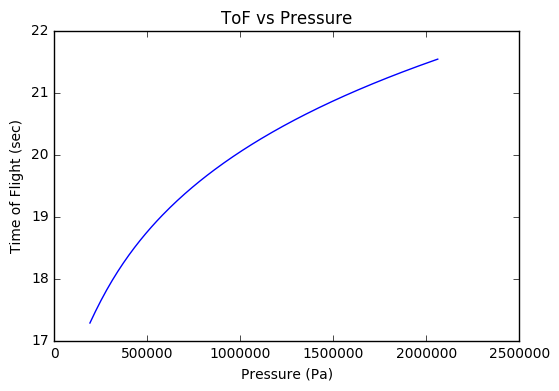

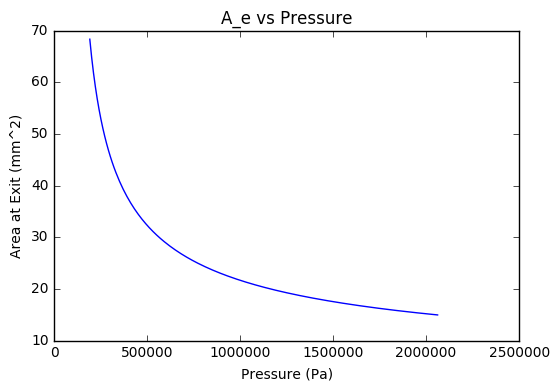

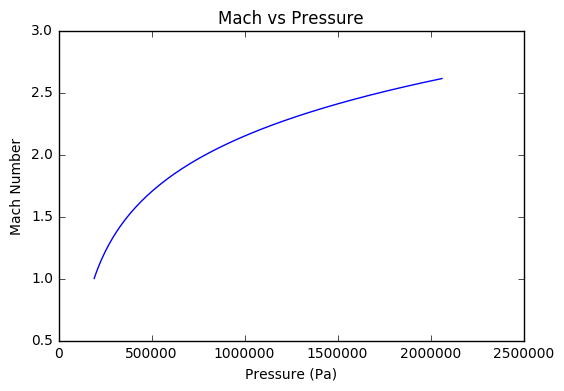

In [60]:
# Time of Flight vs Chamber Pressure

def calc_engine_params(P_o):    
    Ma_e = np.sqrt((2 / (gamma - 1)) \
      * (((P_o / P_b) ** (           \
        (gamma - 1) / gamma))-1))  
    
    T_b = T_o/(1+(((gamma-1)/2)*(Ma_e)))

    V_e = np.sqrt(((T_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * ((P_o / P_b) ** (       \
        (gamma - 1) / gamma))-1)

    Isp = V_e / g
    
    F_nom = wet_mass * g    
    
    mass_flow = F_nom / V_e             # kg/s    
    
    A_e = (mass_flow*(1+(gamma-1)*((Ma_e**2)/2))**((gamma+1)/(2*(gamma-1))))/(Ma_e*P_o*np.sqrt((molar_mass*gamma)/(R*T_o)))
    
    t_flight = prop_mass / mass_flow    # sec
    
    return t_flight, A_e, Ma_e

# p_o_min calculated above
p_step = 10000
p_o_min = P_o_critical  # Minimum pressure for choked flow state
p_reg_max = 2.068e6     # Maximum pressure from the regulator

# Sweep the pressure and plot the time of flight
p_array = np.arange(int(p_o_min), int(p_reg_max), p_step)
ToF_array, Ae_array, Mae_array = calc_engine_params(p_array)
Ae_array *= 1e6     # Convert from m^2 to mm^2

plt.figure(1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Time of Flight (sec)')
plt.title('ToF vs Pressure')
plt.plot(p_array, ToF_array)

plt.figure(2)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Area at Exit (mm^2)')
plt.title('A_e vs Pressure')
plt.plot(p_array, Ae_array)
plt.show()

plt.figure(2)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Mach Number')
plt.title('Mach vs Pressure')
plt.plot(p_array, Mae_array)
plt.show()


<b>Analysis:</b>
> - As pressure increases, time of flight increases
> - At lower pressures, we observe larger variations in time of flight
> - At higher pressures, time of flight variations much smaller
> - From min to max chamber pressure, time of flight varies by 4 seconds

> <br>

>As expected, we asymptote near a theoretical ToF limit near 25 seconds.

>Why is this not value not 25 seconds? <br>
Because we initially guessed a V_e limit of 1000 m/s based on a reference table, these results more accurately reflect the expected time of flight based on our vehicle model. However, our results are in family with the reference materal, so we can feel a little more confident about them.

> <br>

> What we know about higher pressures:
> - Higher pressures require fabrication of nozzles with much smaller cross-sectional areas
> - Higher pressures require heavier plumbing
> - Controlling higher pressures requires greater power (this become more problematic as actuator bandwidth increases)


Selecting a pressure:
> - The pressure we select must be greater than the minimum chamber pressure required to achieve choked flow and below the regulator's maximum pressure
> - We don't want to select a pressure too close to the minimum since we may break choked flow during throttle down when landing (the idea is to have plenty of pressure margin)
> - Ideally, the pressure we select would be easy and cost-effictive to sense. Generally speaking, sensor mass, size, and cost increase with pressure
> - Select a pressure that doesn't require machining very small cross-sectional areas

<b>Selected nominal pressure: 500,000pa (~70psi)</b>

Let's now calculate the engine parameters:

In [61]:
P_o = 5e5 # Pa (~70psi)

ToF, A_e, Ma_e = calc_engine_params(P_o)

print ("Selected Chamber Pressure: %.2f Pa" % P_o)
print ("Calculated ToF: %0.2f sec" % ToF)
print ("Calculated A_e: %0.8f m^2" % A_e)
print ("Calculated A_e: %.2f mm^2" % (A_e*1e6))
print ("Calculated Exit Diameter: %.2f mm" % (2*(np.sqrt((A_e*1e6)/np.pi))) )

Selected Chamber Pressure: 500000.00 Pa
Calculated ToF: 18.75 sec
Calculated A_e: 0.00003230 m^2
Calculated A_e: 32.30 mm^2
Calculated Exit Diameter: 6.41 mm


#### Step 7: Determine Cross-Sectional Area at the Exit and Throat

Up until step 6, we've been assuming only a converging nozzle where the exit of the nozzle is the throat. The next step is to add a diverging section at the end of the throat to maximize V_e. Let's get all De Laval on this! The key to this is to calculate the cross-sectional area at the exit first, then to calculate the cross-sectional area at the throat.

\begin{equation}
\frac{A_e}{A_t} = \frac{1}{M_e}\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{\gamma+1}{2(\gamma-1)} \tag{16} 
\end{equation}

Since we already know A_e, we can now solve for A_t:

\begin{equation}
A_t = A_e M_e\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{-\gamma+1}{2(\gamma-1)}
\end{equation}

In [62]:
print ("Exit Mach: %.2f\n" % Ma_e)

A_t = (A_e*Ma_e)*(((2/(gamma+1))*(1+((gamma-1)/2)*(Ma_e**2)))**((-(gamma+1))/(2*(gamma-1))))

print ("Area at Throat: %0.8f m^2" % A_t)
print ("Area at Throat: %.2f mm^2" % (A_t*1e6))
print ("Throat Diameter: %.2f mm \n" % (2*(np.sqrt((A_t*1e6)/np.pi))) )

print ("Area at Exit: %0.8f m^2" % A_e)
print ("Area at Exit: %.2f mm^2" % (A_e*1e6))
print ("Exit Diameter: %.2f mm \n" % (2*(np.sqrt((A_e*1e6)/np.pi))) )

# Ae/At Ratio
A_e_A_t = A_e / A_t
print ("Ae/At Ratio: %0.2f" % A_e_A_t)

Exit Mach: 1.70

Area at Throat: 0.00002415 m^2
Area at Throat: 24.15 mm^2
Throat Diameter: 5.54 mm 

Area at Exit: 0.00003230 m^2
Area at Exit: 32.30 mm^2
Exit Diameter: 6.41 mm 

Ae/At Ratio: 1.34


<b>Step 8: Model Propellant as a Real Gas</b>

TODO: MODEL TANK PRESSURE AND TEMPERATURE DROP, THIS WILL EFFECT T_O!!!
<br>
TODO: Rename function and variable names
<br>
[ADD DIAGRAM OF SYSTEM]
<br>
Darn Joule–Thomson effect...
<br>
MODEL BOTTLE BLOW-DOWN HERE
\begin{equation}
\frac{P_i}{P_f} = \left(\frac{T_i}{T_f}\right)^\left(\frac{\gamma}{\gamma-1}\right)
\end{equation}

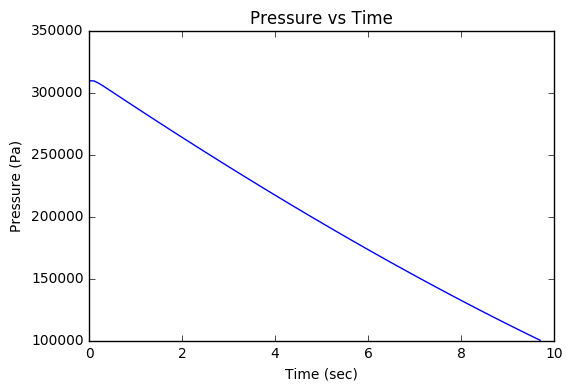

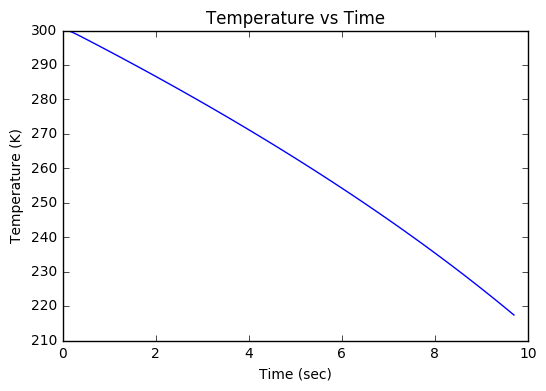

In [71]:
def tank_sim(T_i, tank_volume, prop_mass, mass_flow, dt):
        
    tank_time = 0.0
    
    tank_T_i = tank_T_f = T_i
    
    tank_P_i = tank_P_f = ((prop_mass/molar_mass)*R*(tank_T_i))/tank_volume
    
    time, tank_P, tank_T = [0],[tank_P_f],[tank_T_f]
    
    while tank_P_f >= P_atm:
        tank_P_f = ((prop_mass/molar_mass)*R*tank_T_f)/tank_volume
        tank_T_f = tank_T_i/((tank_P_i/tank_P_f)**((gamma-1)/gamma))
        
        tank_P_i = tank_P_f
        tank_T_i = tank_T_f
        prop_mass = prop_mass - (mass_flow*dt)
        tank_time = tank_time + dt
        
        time.append(tank_time)
        tank_P.append(tank_P_f)
        tank_T.append(tank_T_f)
        
    return time, tank_P, tank_T

time, tank_P, tank_T = tank_sim(300, tank_volume, prop_mass/100, mass_flow/100, 0.1)

plt.figure(1)
plt.xlabel('Time (sec)')
plt.ylabel('Pressure (Pa)')
plt.title('Pressure vs Time')
plt.plot(time, tank_P)

plt.figure(2)
plt.xlabel('Time (sec)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs Time')
plt.plot(time, tank_T)

plt.show()

<b>Step 9: Recalculate Vehicle and Engine Parameters</b>

TODO: Show how T_o drops as tank pressure decreases. Propose the solution of heating the incoming air, show how it affects flight time. Calculat the total energy required to raise the temperature.

Finally, we print out all the important vehicle parameters:

In [64]:
# Print out final parameters
print ("Nominal Chamber Pressure: %.2f Pa\n" % P_o)
print ("Exit Mach Number: %.2f\n" % Ma_e)
print ("Time of Flight: %0.2f sec\n" % ToF)
print ("A_e: %.2f mm^2" % (A_e*1e6))
print ("Exit Diameter: %.2f mm\n" % (2*(np.sqrt((A_e*1e6)/np.pi))) )
print ("A_t: %.2f mm^2" % (A_t*1e6))
print ("Throat Diameter: %.2f mm \n" % (2*(np.sqrt((A_t*1e6)/np.pi))) )
print ("Ae/At Ratio: %0.2f" % A_e_A_t)

Nominal Chamber Pressure: 500000.00 Pa

Exit Mach Number: 1.70

Time of Flight: 18.75 sec

A_e: 32.30 mm^2
Exit Diameter: 6.41 mm

A_t: 24.15 mm^2
Throat Diameter: 5.54 mm 

Ae/At Ratio: 1.34


#### Sources and Citation: 

Sutton, George P., and Oscar Biblarz. Rocket Propulsion Elements. New York: John Wiley & Sons, 2010. Print.

Ãengel, Yunus A., and Michael A. Boles. Thermodynamics: An Engineering Approach. New York: McGraw-Hill Education, 2015. Print.